In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr,spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from statsmodels.api import Logit
import xgboost as xgb
# from imblearn.over_sampling import SMOTE
import random

import holidays
import requests
from time import sleep
from shutil import copyfile
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [3]:
# # To find out where the pyspark
# import findspark
# findspark.init()

# # Creating Spark Context
# from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import UserDefinedFunction as udf
from pyspark.sql.types import StringType, IntegerType, DecimalType, DoubleType

In [4]:
from pyspark.ml.feature import VectorAssembler,CountVectorizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
"""SimpleApp.py"""
spark = SparkSession.builder.appName("FirstSparkApp").getOrCreate()

In [7]:
df_spark = spark.read\
    .format("com.databricks.spark.csv")\
    .option("header", "true") \
    .option("mode", "DROPMALFORMED")\
    .option("inferSchema", "true")\
    .load('/home/arditto_trianggada3/Workspace/ds-ovo-test/dataset/trip_merge_4_fe_all.csv')

In [8]:
df1 = df_spark.limit(10).toPandas()

In [9]:
df1.head(5)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_longitude_bin,pickup_latitude_bin,dropoff_longitude_bin,dropoff_latitude_bin,pickup_addr_zipcode,pickup_addr_place,pickup_addr_neighborhood,pickup_addr_sublocal,pickup_addr_local,pickup_addr_administrative_area_level_2,dropoff_addr_zipcode,dropoff_addr_place,dropoff_addr_neighborhood,dropoff_addr_sublocal,dropoff_addr_local,dropoff_addr_administrative_area_level_2,pickup_to_dropoff_zipcode,pickup_to_dropoff_place,pickup_to_dropoff_neighborhood,pickup_to_dropoff_sublocal,pickup_to_dropoff_local,pickup_to_dropoff_administrative_area_level_2,pickup_month,pickup_dayofweek,pickup_hour,dropoff_month,dropoff_dayofweek,dropoff_hour,is_public_holiday,is_weekend,is_holiday,trip_night,trip_late_night,trip_dist_euclidean,trip_dist_manhattan
0,91F6EB84975BBC867E32CB113C7C2CD5,AD8751110E6292079EB10EB9481FE1A6,CMT,1,N,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.5,-73.957855,40.765320,-73.976273,40.785648,CRD,11.0,1.0,0.5,2.50,0.0,15.00,-73.955,40.770,-73.975,40.790,10065.0,E 67th St,None,Manhattan,New York,New York County,10024.0,W 83rd St,None,Manhattan,New York,New York County,10065.0_10024.0,E 67th St_W 83rd St,nan_nan,Manhattan_Manhattan,New York_New York,New York County_New York County,4,Thursday,18,4,Thursday,19,0,0,0,1,0,0.027431,0.038746
1,C1B9DA774DC2BBC6DE27CE994E7F44A0,E1B595FD55E4C82C1E213EB17438107A,CMT,1,N,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.6,-73.982880,40.754990,-74.009186,40.715374,CRD,16.5,1.0,0.5,3.60,0.0,21.60,-73.980,40.755,-74.005,40.720,10036.0,Verizon Plaza,None,Manhattan,New York,New York County,10007.0,Warren St,None,Manhattan,New York,New York County,10036.0_10007.0,Verizon Plaza_Warren St,nan_nan,Manhattan_Manhattan,New York_New York,New York County_New York County,4,Thursday,17,4,Thursday,18,0,0,0,1,0,0.047555,0.065922
2,9BA84250355AB3FC031C9252D395BF8A,16BB0D96A0DCC853AEC7F55C8D6C71E0,CMT,1,N,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.9,-73.978119,40.763451,-73.955666,40.776642,CRD,10.0,1.0,0.5,3.45,0.0,14.95,-73.975,40.765,-73.955,40.780,10019.0,7th Ave,None,Manhattan,New York,New York County,10028.0,E 81st St,None,Manhattan,New York,New York County,10019.0_10028.0,7th Ave_E 81st St,nan_nan,Manhattan_Manhattan,New York_New York,New York County_New York County,4,Thursday,18,4,Thursday,18,0,0,0,1,0,0.026041,0.035644
3,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,N,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.6,-74.006371,40.744755,-73.961662,40.761082,CRD,15.0,0.5,0.5,3.20,0.0,19.20,-74.005,40.745,-73.960,40.765,10011.0,W 19th St,None,Manhattan,New York,New York County,10022.0,E 60th St,None,Manhattan,New York,New York County,10011.0_10022.0,W 19th St_E 60th St,nan_nan,Manhattan_Manhattan,New York_New York,New York County_New York County,4,Thursday,20,4,Thursday,20,0,0,0,1,1,0.047597,0.061036
4,EE75E5927D00739AC342810C336A825E,1B4E92431F9DA4D49874EC76E769E874,CMT,1,N,2013-04-05 02:48:11,2013-04-05 02:51:21,2,189,0.7,-73.985191,40.754932,-73.990776,40.747997,CRD,4.5,0.5,0.5,1.10,0.0,6.60,-73.985,40.755,-73.990,40.750,10036.0,Verizon Plaza,None,Manhattan,New York,New York County,10120.0,West 33rd Street,None,Manhattan,New York,New York County,10036.0_10120.0,Verizon Plaza_West 33rd Street,nan_nan,Manhattan_Manhattan,New York_New York,New York County_New York County,4,Friday,2,4,Friday,2,0,0,0,0,1,0.008904,0.012520


In [7]:
class labelEnc():
    """
    Label Encoding
    """
    def __init__(self, categorical_features):
        self.key = categorical_features
        self.enc = [LabelEncoder() for c in categorical_features]
      
    def fit(self,X, y=None):
        y = np.array(X)
        self.categorical_feat_classes = {}
        for i in range(len(self.key)):
            c = self.key[i]
            self.enc[i] = self.enc[i].fit(y[:,c])
            self.categorical_feat_classes[c] = self.enc[i].classes_
        return self
      
    def transform(self,X):
        y = np.array(X)
        for i in range(len(self.key)):
            c = self.key[i]
            y[:,c] = self.enc[i].transform(y[:,c])
        return y
      
    def fit_transform(self,X, y=None):
        self.fit(X,y)
        y = np.array(X)
        for i in range(len(self.key)):
            c = self.key[i]
            y[:,c] = self.enc[i].transform(y[:,c])
        return y
    
class oneHotEnc():
    """
    One Hot Encoding
    """
    def __init__(self, categorical_features, fit_onehot):
        self.key = categorical_features
        self.enc = fit_onehot.set_params(categorical_features=categorical_features)

    def fit(self, X, y=None):
        if len(self.key)>0:
            #global categorical_onehot_idx,categorical_onehot_nval 
            self.enc = self.enc.fit(X,y)
            categorical_onehot_idx = self.enc.feature_indices_
            categorical_onehot_nval = self.enc.n_values_
            self.categorical_onehot_idx = categorical_onehot_idx
            self.categorical_onehot_nval = categorical_onehot_nval
        return self

    def transform(self, X):
        if len(self.key)>0:
            y = self.enc.transform(X)
            y = y if type(y)==np.ndarray else y.toarray()
        else:
            y=X
        return y
      
    def fit_transform(self,X, y=None):
        if len(self.key)>0:
            y = self.fit(X,y).transform(X)
            y = y if type(y)==np.ndarray else y.toarray()
        return y

def getColnames(le,onehotenc,df):
    if len(onehotenc.key)>0:
        categorical_onehot_idx = onehotenc.enc.feature_indices_
        categorical_onehot_nval = onehotenc.enc.n_values_
        colname = []
        k=0
        for i in categorical_onehot_idx[:-1]:
            feat = list_col_cat[k]
            for j in range(categorical_onehot_nval[k]):
                val = le.categorical_feat_classes[le.key[k]][j]
                colname.append("{}_{}".format(feat,val))
            k+=1
        lcol_num = [x for x in df.dtypes.index.values if not(x in list_col_cat)]
        for i in lcol_num:
            colname.append("{}".format(i))
    else:
        colname = df.columns.values
    return colname

In [8]:
## Save model
class bst_models():
  
  def __init__(self,colname, score_method="mean"):
    self.model = []
    self.colname = colname
    self.score_method = score_method
  
  def add_model(self, model):
    self.model.append(model)
    return self
  
  def predict(self,X):
    d = xgb.DMatrix(X,feature_names=self.colname)
    preds=[]
    for m in self.model:
      pred = m.predict(d)
      preds.append(list(pred))
      
    K = len(preds)
    nrow = len(preds[0])
    self.K = K
    self.nrow = nrow
    pred = []
    for i in range(nrow):
      sum1=0
      for j in range(K):
        if self.score_method == "max":
          sum1 = max(sum1, preds[j][i])
        else:
          sum1+=preds[j][i]
      if self.score_method == "max":
        pred.append(sum1)
      else:
        pred.append(sum1/K)
      
    return pd.Series(pred)
  
  def get_importances(self):
    imp = dict()
    cols = self.model[0].feature_names
    for col in cols:
      imp1=0
      k1 = 0
      for j in range(self.K):
        try:
          imp1+=self.model[j].get_score()[col]
        except (KeyError):
          pass
        k1 += 1
      imp[col] = imp1 / k1
    imp = pd.Series(imp).sort_values(ascending=False)
    return imp


In [9]:
# df = df_spark.limit(1000000).toPandas()

In [10]:
df_orig = pd.read_csv("./dataset/trip_merge_4_fe_all.csv")

/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
Nall = df_orig.shape[0]
Nsample = 1000000

isample = random.sample(range(Nall),Nsample)
df = df_orig.loc[isample,:].reset_index(drop=True)

In [80]:
list_col_excl = [
    'medallion',
    'hack_license',
    'vendor_id',
    'pickup_addr_neighborhood',
    'dropoff_addr_neighborhood',
    'store_and_fwd_flag',
    'dropoff_addr_local','pickup_addr_local',
    'mta_tax','payment_type','tip_amount','surcharge','tolls_amount','total_amount',
    'pickup_longitude_bin','dropoff_longitude_bin',
    'pickup_longitude','dropoff_longitude',
    'pickup_latitude_bin','dropoff_latitude_bin',
    'pickup_latitude','dropoff_latitude',
    'dropoff_datetime','pickup_datetime',
    'is_weekend','is_public_holiday',
    'dropoff_month','pickup_month'
]

df = df.drop(list_col_excl,axis=1)

In [81]:
## Menghitung Nilai Null
df_cnt = df.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)
df_cnt

dropoff_addr_sublocal                            0.007096
pickup_addr_place                                0.005733
dropoff_addr_place                               0.005606
dropoff_addr_administrative_area_level_2         0.005560
pickup_addr_administrative_area_level_2          0.004077
pickup_addr_sublocal                             0.003490
dropoff_addr_zipcode                             0.000044
pickup_addr_zipcode                              0.000041
trip_dist_manhattan                              0.000000
trip_dist_euclidean                              0.000000
passenger_count                                  0.000000
trip_time_in_secs                                0.000000
trip_distance                                    0.000000
fare_amount                                      0.000000
pickup_to_dropoff_zipcode                        0.000000
pickup_to_dropoff_place                          0.000000
pickup_to_dropoff_neighborhood                   0.000000
pickup_to_drop

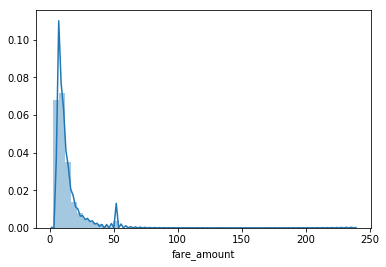

In [82]:
## ---------------------------------------------------------------------
## Null imputation
## ---------------------------------------------------------------------
data = df.copy()

## Menghitung Nilai Null
df_cnt = data.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)

## Mengambil column dengan Null lebih dari 20% kecuali n tahun restruk
feat_null = df_cnt[df_cnt>=0.2].index.tolist()
feat_null = [x for x in feat_null if not(x in [
 'fare_amount'
])]

## Membuang Kolom data dengan Null lebih dari 20%
lcol = data.columns.values
lcol = [x for x in lcol if not(x in feat_null)]
data = data.loc[:,lcol].reset_index(drop=True)

## Cek kolom data
tmp = data.apply(lambda x: x.count(), axis=0)
tmp = [tmp.index[i] for i in range(len(tmp)) if tmp[i]<data.shape[0]]

## Kolom identitas
exc_col = []
exc_col = np.append(exc_col,[
 'fare_amount'
])

## Missing Values Handling selain kolom identitas
for col in data.columns.values:
    if not(col in exc_col):
#         print(col)
        ds = data[col]
        typ = ds.dtype
        ## Ganti dengan modus untuk object dan categorical
        if typ==object:
            ds = ds.fillna(ds.mode()[0])
        elif type(typ)==pd.core.dtypes.dtypes.CategoricalDtype:
            ds = ds.fillna(ds.mode()[0])
        ## Untuk numeric ganti dengan median
        else:
            ds = ds.fillna(ds.median())
        data[col] = ds
        

### Data minus jadi 0
#for col in data.columns.values[M:N+1]:
#  data[col] = data[col].map(lambda x: x if x>0 else 0)
#data = data.reset_index(drop=True)

# target_count = data['fare_amount_sum'].value_counts()
# print('Class 0:', target_count[0])
# print('Class 1:', target_count[1])
# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
# target_count.plot(kind='bar', title='Count (TARGET)');

sns.distplot(data['fare_amount'])

df = data.copy()

In [83]:
## Menghitung Nilai Null
df_cnt = df.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)
df_cnt

trip_dist_manhattan                              0.0
trip_dist_euclidean                              0.0
passenger_count                                  0.0
trip_time_in_secs                                0.0
trip_distance                                    0.0
fare_amount                                      0.0
pickup_addr_zipcode                              0.0
pickup_addr_place                                0.0
pickup_addr_sublocal                             0.0
pickup_addr_administrative_area_level_2          0.0
dropoff_addr_zipcode                             0.0
dropoff_addr_place                               0.0
dropoff_addr_sublocal                            0.0
dropoff_addr_administrative_area_level_2         0.0
pickup_to_dropoff_zipcode                        0.0
pickup_to_dropoff_place                          0.0
pickup_to_dropoff_neighborhood                   0.0
pickup_to_dropoff_sublocal                       0.0
pickup_to_dropoff_local                       

In [84]:
df.dtypes

rate_code                                          int64
passenger_count                                    int64
trip_time_in_secs                                  int64
trip_distance                                    float64
fare_amount                                      float64
pickup_addr_zipcode                              float64
pickup_addr_place                                 object
pickup_addr_sublocal                              object
pickup_addr_administrative_area_level_2           object
dropoff_addr_zipcode                             float64
dropoff_addr_place                                object
dropoff_addr_sublocal                             object
dropoff_addr_administrative_area_level_2          object
pickup_to_dropoff_zipcode                         object
pickup_to_dropoff_place                           object
pickup_to_dropoff_neighborhood                    object
pickup_to_dropoff_sublocal                        object
pickup_to_dropoff_local        

In [85]:
# df['pickup_to_dropoff_local_set'] = df['pickup_to_dropoff_local_set'].map(lambda x: ','.join(np.sort(x.replace('[','').replace(']','').replace(', ',',').split(',')).tolist()))


In [86]:
list_col_excl1 = [
 'pickup_to_dropoff_zipcode',
 'pickup_to_dropoff_place',
 'pickup_to_dropoff_neighborhood',
 'pickup_to_dropoff_sublocal',
 'pickup_to_dropoff_local',
 'pickup_to_dropoff_administrative_area_level_2',
 'pickup_addr_place',
 'dropoff_addr_place'
]

list_col_excl1 = [x for x in list_col_excl1 if not(x in list_col_excl)]

In [87]:
target_var = 'fare_amount'
dtype = df.dtypes.drop(list_col_excl1+[target_var])
list_col = dtype.index.values.tolist()

X = df.loc[:, list_col]
Y = df[target_var]

In [89]:
list_col_cat = [x for x in X.columns.values if ((X[x].dtypes==object) or (type(X[x].dtypes)==pd.core.dtypes.dtypes.CategoricalDtype))]
list_idx_cat = [i for i in range(len(X.columns.values)) if X.columns.values[i] in list_col_cat]

# Label Encoding
le = labelEnc(categorical_features=list_idx_cat)
le.fit(X)
categorical_feat_classes = le.categorical_feat_classes

### One Hot Encoding
onehotenc = oneHotEnc(categorical_features=list_idx_cat, fit_onehot=OneHotEncoder())

### Feature scaling
scaler = StandardScaler()

### Merge preprocess pipeline
X_1 = le.transform(X)
# X_train1 = le.transform(X_train)
# X_test1 = le.transform(X_test)

# Preprocessing
pipeline = [
  # ('label_enc', le),
  ('one_hot_enc', onehotenc),
  #  ('scale', scaler),
  #  ('feature_selection', selector)
]
pipeline_preprocess = Pipeline(pipeline)
pipeline_preprocess.fit(X_1, Y)

# Get colname of new dataset features
onehotenc = pipeline_preprocess.steps[0][1]
categorical_onehot_idx = onehotenc.enc.feature_indices_
categorical_onehot_nval = onehotenc.enc.n_values_
colname = []
k=0
for i in categorical_onehot_idx[:-1]:
  feat = list_col_cat[k]
  for j in range(categorical_onehot_nval[k]):
    val = categorical_feat_classes[list_idx_cat[k]][j]
    colname.append("{}_{}".format(feat,val))
  k+=1
lcol_num = [x for x in dtype.index.values if not(x in list_col_cat)]
for i in lcol_num:
  colname.append("{}".format(i))

X_1 = pipeline_preprocess.transform(X_1)
# X_train1 = pipeline_preprocess.transform(X_train1)
# X_test1 = pipeline_preprocess.transform(X_test1)

/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/sklearn/ut

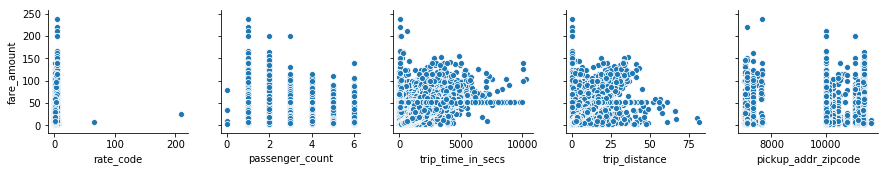

In [90]:
tmp = X.copy()
tmp['fare_amount'] = Y
pp = sns.pairplot(data=tmp, y_vars=['fare_amount'], x_vars=list_col[0:5])

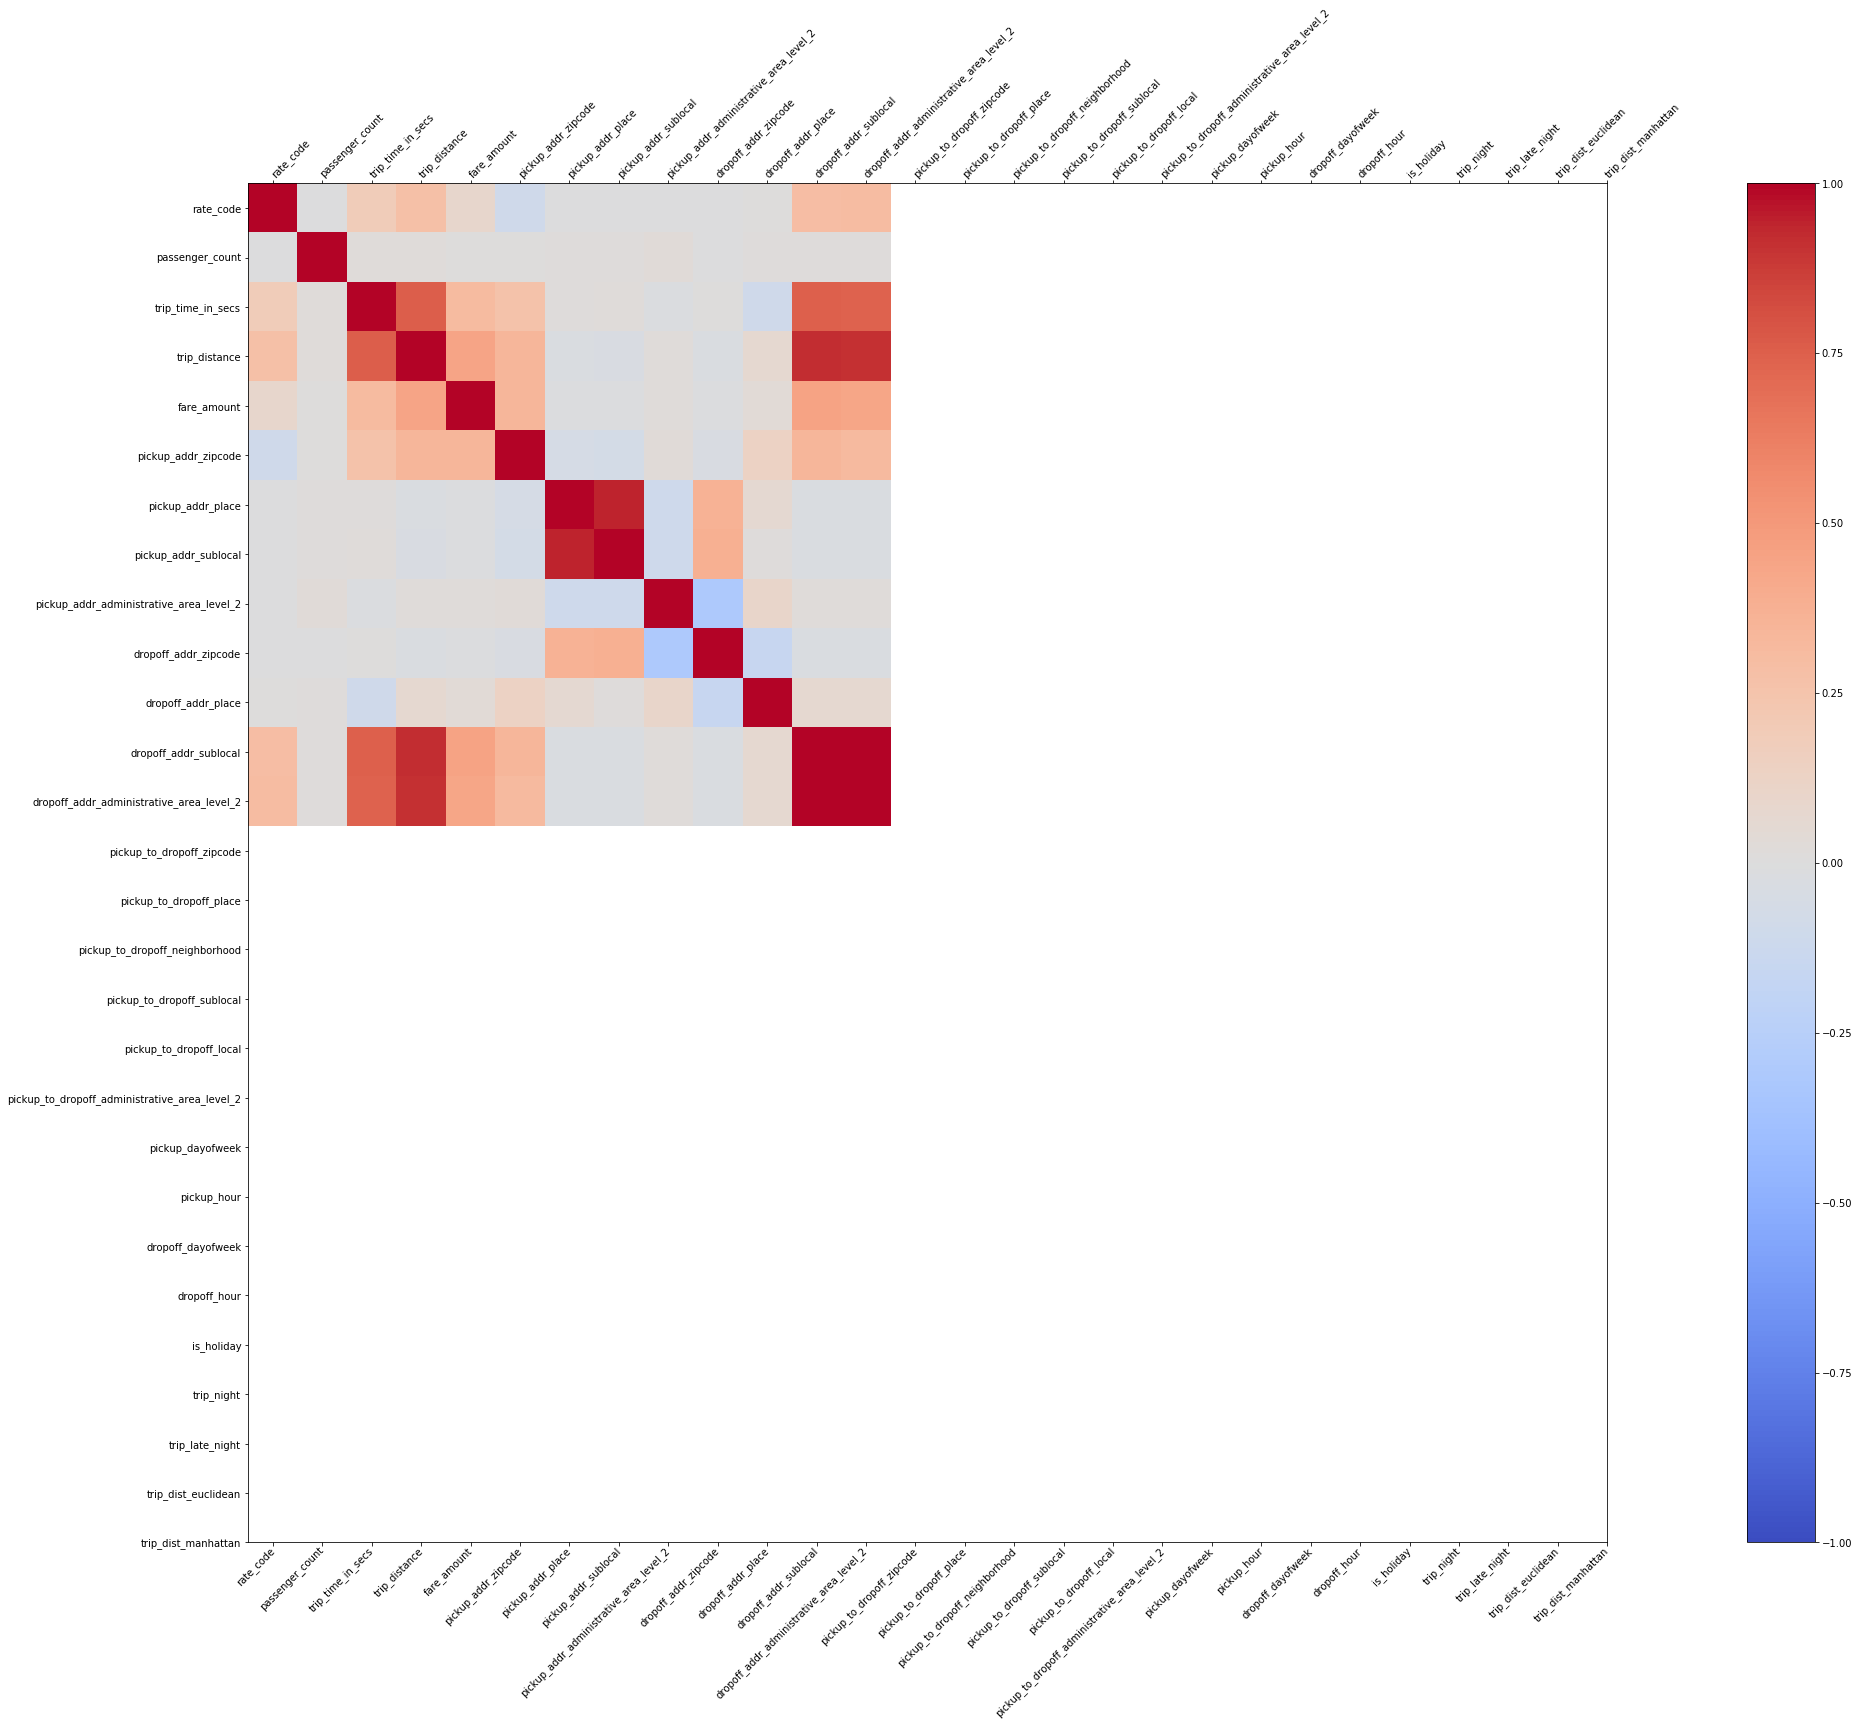

In [91]:
corr = X.corr()
fig = plt.figure(figsize=(50,25))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="left", va="center",rotation_mode="anchor")

# ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
# ax.set_yticklabels(ax.get_yticklabels(),rotation=60)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()

plt.show()
# plt.savefig('filename.png')

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X_1, Y, test_size=0.3, random_state=100)
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [93]:
### Resampling unbalanced dataset
# (1) Over-sampling with SMOTE
# def_ratio = 0.09
# sm = SMOTE(random_state=42, ratio={0:Y_train.value_counts()[0],1:int(Y_train.value_counts()[0]*(def_ratio/(1-def_ratio)))})
# sm.fit(X_train,Y_train)
# X_train_upsampled, Y_train_upsampled = sm.sample(X_train, Y_train)

X_train_upsampled = X_train
Y_train_upsampled = Y_train

In [94]:
dtrain = xgb.DMatrix(X_train_upsampled, label=Y_train_upsampled)
dtest  = xgb.DMatrix(X_test , label=Y_test )

/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [95]:
K = 4
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [96]:
xgb_preds = []
bst = bst_models(colname=colname,score_method="mean")

In [97]:
def r2_metric(preds, dtrain):
    labels = dtrain.get_label()
    r2 = 1 - (sum((labels-preds )**2)/sum((labels-np.mean(labels))**2))
    return 'r2',r2

In [98]:
for train_index, test_index in kf.split(X_train_upsampled):
    train = X_train_upsampled; target_train = Y_train_upsampled
    train_X, valid_X = train[train_index], train[test_index]
    train_y, valid_y = target_train[train_index], target_train[test_index]
    
    # Create logistic regression object
    d_train = xgb.DMatrix(train_X, label=train_y,feature_names=colname)
    d_valid = xgb.DMatrix(valid_X, label=valid_y,feature_names=colname)

    xgb_params = {
        'eta': 0.03,
        'max_depth': 4,
        'subsample': 0.75,
        'objective': 'reg:linear',
        'silent': 1,
        'colsample_bytree': 0.8,
        'eval_metric': ['rmse']
    }
    early_stopping = 80
    num_round = 400
    evallist  = [(d_train,'train'), (d_valid,'eval')]
    
    model = xgb.train(
      xgb_params, 
      d_train, 
      num_round,
      evallist,
      feval=r2_metric,
      early_stopping_rounds=early_stopping
    )
    bst.add_model(model)

[0]	train-rmse:14.5902	eval-rmse:14.6265	train-r2:-1.3699	eval-r2:-1.36445
Multiple eval metrics have been passed: 'eval-r2' will be used for early stopping.

Will train until eval-r2 hasn't improved in 80 rounds.
[1]	train-rmse:14.1698	eval-rmse:14.2044	train-r2:-1.23524	eval-r2:-1.23009
[2]	train-rmse:13.7622	eval-rmse:13.7961	train-r2:-1.10843	eval-r2:-1.10363
[3]	train-rmse:13.37	eval-rmse:13.4028	train-r2:-0.990025	eval-r2:-0.985477
[4]	train-rmse:12.9897	eval-rmse:13.0223	train-r2:-0.87856	eval-r2:-0.874205
[5]	train-rmse:12.6169	eval-rmse:12.648	train-r2:-0.772126	eval-r2:-0.768103
[6]	train-rmse:12.2567	eval-rmse:12.2875	train-r2:-0.672334	eval-r2:-0.668689
[7]	train-rmse:11.9104	eval-rmse:11.9401	train-r2:-0.57924	eval-r2:-0.575713
[8]	train-rmse:11.5738	eval-rmse:11.6023	train-r2:-0.491355	eval-r2:-0.487904
[9]	train-rmse:11.2495	eval-rmse:11.2766	train-r2:-0.408854	eval-r2:-0.405493
[10]	train-rmse:10.9298	eval-rmse:10.9564	train-r2:-0.329931	eval-r2:-0.326773
[11]	train-rms

In [99]:
# Predict testing data
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)

In [100]:
compare = {
  'train': pd.DataFrame({'true':Y_train,'pred':y_train_pred}),
  'test': pd.DataFrame({'true':Y_test,'pred':y_test_pred})
}

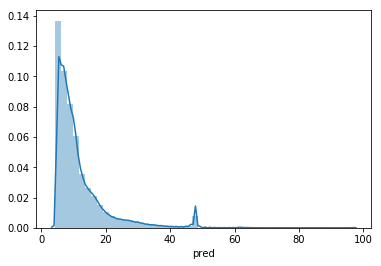

In [101]:
# Model evaluation: KS
test_compare = compare['train']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
sns.distplot(a=disp.loc[:,'pred'], hist=True)

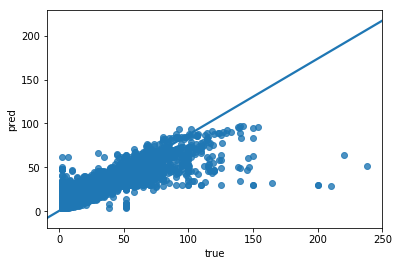

In [102]:
# Model evaluation: KS
test_compare = compare['train']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
ax = sns.regplot(x="true", y="pred", data=disp)

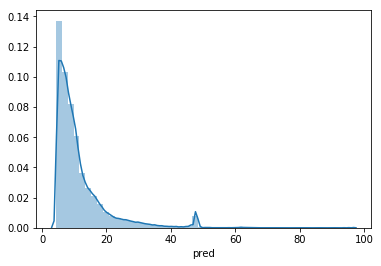

In [103]:
# Model evaluation: KS
test_compare = compare['test']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
sns.distplot(a=disp.loc[:,'pred'], hist=True)

Text(75, 0, 'Outlier Threshold of Fare Amount')

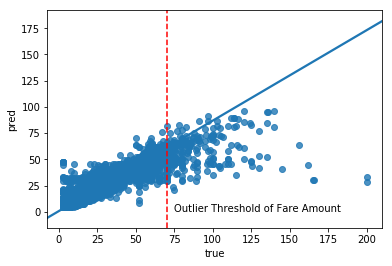

In [116]:
# Model evaluation: KS
test_compare = compare['test']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
ax = sns.regplot(x="true", y="pred", data=disp)
ax.axvline(70, ls='--',color='red')

ax.text(75,0, "Outlier Threshold of Fare Amount")

In [106]:
df.fare_amount.describe()

count    1000000.000000
mean          12.160718
std            9.493119
min            2.500000
25%            6.500000
50%            9.500000
75%           14.000000
max          238.000000
Name: fare_amount, dtype: float64

In [111]:
df.fare_amount.quantile(0.999)

70.0

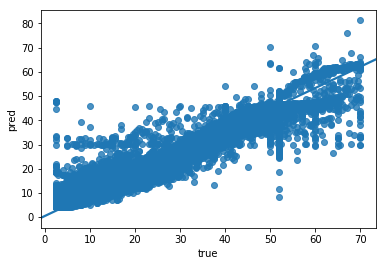

In [114]:
# Model evaluation: KS
test_compare = compare['test']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
ax = sns.regplot(x="true", y="pred", data=disp.loc[disp.true<=70.0,:])

In [117]:
print("RMSE: {}".format(np.sqrt(mean_squared_error(Y_train,y_train_pred))))
print("R2  : {}".format(r2_score(Y_train,y_train_pred)))

RMSE: 2.139337264521463
R2  : 0.9491420111259119


In [107]:
print("RMSE: {}".format(np.sqrt(mean_squared_error(Y_test,y_test_pred))))
print("R2  : {}".format(r2_score(Y_test,y_test_pred)))

RMSE: 2.193567723999832
R2  : 0.9467834874967349


In [108]:
for i,mdl in enumerate(bst.model):
    print("Model:{}".format(i))
    print(pd.Series(mdl.get_fscore()).sort_values(ascending=False))

Model:0
trip_time_in_secs                                              342
trip_distance                                                  299
rate_code                                                      242
trip_dist_euclidean                                            167
dropoff_addr_zipcode                                            78
trip_dist_manhattan                                             21
pickup_addr_zipcode                                             11
pickup_addr_administrative_area_level_2_Essex County            10
dropoff_addr_administrative_area_level_2_New York County         8
pickup_addr_administrative_area_level_2_Bergen County            6
dropoff_addr_administrative_area_level_2_Hudson County           5
dropoff_addr_administrative_area_level_2_Essex County            5
pickup_addr_administrative_area_level_2_Westchester County       4
pickup_addr_sublocal_Queens                                      4
pickup_addr_administrative_area_level_2_New York Count